사진 파일을 이용하여 추적 

In [ ]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
EDGES = ((0, 1),
         (0, 2),
         (1, 3),
         (2, 4),
         (0, 5),
         (0, 6),
         (5, 7),
         (7, 9),
         (6, 8),
         (8, 10),
         (5, 6),
         (5, 11),
         (6, 12),
         (11, 12),
         (11, 13),
         (13, 15),
         (12, 14),
         (14, 16))

In [ ]:
#1. 의존성 가져오기
import numpy as np
import tensorflow as tf
import tensorflow_hub as tf_hub

import cv2
from google.colab.patches import cv2_imshow

import matplotlib
import matplotlib.pyplot as plt

In [ ]:
#2. 모델 가져오기
LIGHTNING = "https://tfhub.dev/google/movenet/multipose/lightning/1"
THUNDER = "https://tfhub.dev/google/movenet/singlepose/thunder/4"
IMAGE_SIZE = 256
IMAGE_SIZE = 256


thunder = tf_hub.load(THUNDER)
_movenet = thunder.signatures['serving_default']

In [ ]:
#3. 모델 생성하기
def movenet(img):
  h,w,c =img.shape

  #형태는 (none, height, width, channel)
  img= tf.reshape(img, (1,h,w,c))
  img= tf.image.resize_with_pad(img,IMAGE_SIZE,IMAGE_SIZE)
  img= tf.cast(img,dtype=tf.int32)
  output=_movenet(img)
  return output['output_0'].numpy()[0,0]

In [ ]:
#4. 패딩 조정
def get_coords(landmark,shape):
  h,w,c=shape
  aspect_ratio = w/h
  vpadding = 0 if h > w else (h - w / aspect_ratio)//2
  hpadding = (w-h * aspect_ratio)//2 if h > w else 0
  return int((landmark[1]*w)-hpadding),int((landmark[0]*h)-vpadding)

In [ ]:
#5. 써클 찍기
def show_landmarks(image,threshold=0.2):
  copied=image.copy()
  landmarks=movenet(image)
  for landmark in landmarks:
    if landmark[2]> threshold:
     x,y=get_coords(landmark, copied.shape)
     cv2.circle(copied,
                center=(int(x),int(y)),
                radius=5,
                color=(0,255,0),
                thickness=-1)
     
  return copied


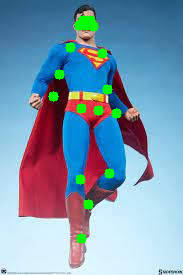

In [ ]:
#6. 이미지 출력해보기
gosu=cv2.imread('다운로드.jpg')
marked=show_landmarks(gosu)
cv2_imshow(marked)

In [ ]:
#7. 점 선으로 연결하기
def show_skeleton(image, threshold=0.2):
  points=set([])
  copied=image.copy()
  landmarks=movenet(copied)

  for edge in EDGES:
    landmark1=landmarks[edge[0]]
    landmark2=landmarks[edge[1]]
    if (landmark1[2]>threshold) and (landmark2[2]>threshold):
      cv2.line(copied,
               get_coords(landmark1,copied.shape),
               get_coords(landmark2,copied.shape),
               color=(0,255,0),
               thickness=3
               )
      if edge[0] not in points:

        points.add(edge[0])

  return copied

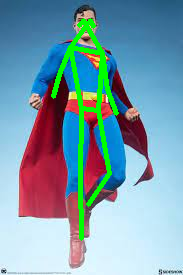

In [ ]:
#8. 이미지 재출력
lined=show_skeleton(gosu)
cv2_imshow(lined)

# 동영상 파일을 이용하여 포즈 추적

In [ ]:
#비디오 시 필요한 것들 
# 의존성, 비디오 출력 함수, 필요인자
#필요인자- fourcc, frame_size,fps

#fourcc = 코덱
#frame_size= 프레임사이즈
#fps= 프레임

#동영상을 열때는 비디오 캡쳐

from IPython.display import HTML
from base64 import b64encode
def show_video(name):
  content = open(name, "rb").read()
  data = "data:video/mp4;base64," + b64encode(content).decode()
  return HTML(f"""<video src={data} width=400 controls/>""")

In [ ]:
filename = "취권.mp4"

In [ ]:
from IPython.display import clear_output

my_video = cv2.VideoCapture(filename)

if not my_video.isOpened():
  raise Exception("Error: Video not opened")

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(my_video.get(cv2.CAP_PROP_FPS))
width, height = my_video.get(cv2.CAP_PROP_FRAME_WIDTH), my_video.get(cv2.CAP_PROP_FRAME_HEIGHT)
frame_size = (int(width), int(height))
my_marked = cv2.VideoWriter("marked.mp4",
                            fourcc,
                            fps,
                            frame_size)

total_frames = my_video.get(cv2.CAP_PROP_FRAME_COUNT)
results = []
while True:
  ret, frame = my_video.read()
  if not ret:
    break
  marked = show_skeleton(frame )
  my_marked.write(marked)


my_video.release()
my_marked.release()

In [ ]:
!ffmpeg -i marked.mp4 -vcodec libx264 coded_marked.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
show_video("coded_marked.mp4")